In [19]:
import pandas as pd

train_df = pd.read_csv('train.csv', index_col =['Id'])
test_df = pd.read_csv('test.csv', index_col = ['Id'])

train_df = train_df.dropna(subset = ['SalePrice'], axis = 0)
x = train_df.drop(columns = ['SalePrice'], axis = 1)
y = train_df['SalePrice']



In [20]:
x.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


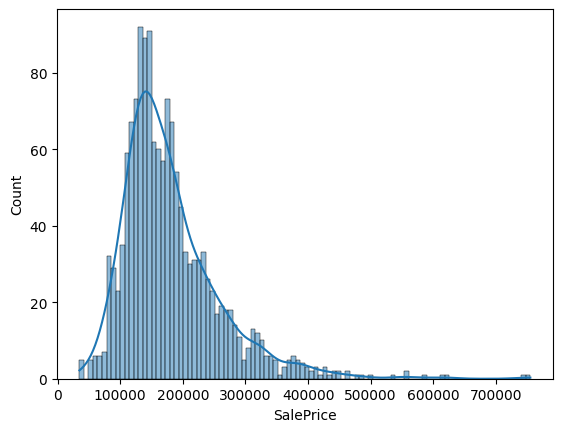

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x = 'SalePrice', data = train_df, kde = True, bins = 100)
plt.show()

# Drop features which contain too much null value
we use functions to find the values but we will decide how to handle those values by person, not by machine

In [22]:
def missing_cols(df: pd.DataFrame, threshold = 0, max_null_percent = 100):   
    missing_col = (df.isnull().sum()/len(df))*100
    missing_col = missing_col[missing_col > threshold].sort_values(ascending = False)
    toomuch_null_col = missing_col[missing_col > max_null_percent].index.tolist()
    
    print(f'now consider drop columns {toomuch_null_col} because they contains more than {max_null_percent}% null value')
  
    return pd.DataFrame({'null value percent': missing_col})

missing_cols(x, threshold = 0, max_null_percent = 80)



now consider drop columns ['PoolQC', 'MiscFeature', 'Alley', 'Fence'] because they contains more than 80% null value


,null value percent
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
MasVnrType,59.726027
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


In [23]:
# we decided to drop dolumns by our missing_cols function output:
x = x.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
test_df_copy = test_df.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)

In [24]:
# test if drop successfully
'Alley' in test_df_copy
# we already drop.

False

# Drop outliers rows in our train_df

In [25]:
# spliting num and cat columns
def split_num_cat(df: pd.DataFrame):
   num = df.select_dtypes(include=['number']).columns.tolist()
   cat = df.select_dtypes(include=['object', 'category']).columns.tolist()
  
   return num, cat


for col in ['MSSubClass', 'MoSold', 'YrSold']:
    if col in x.columns:
        x[col] = x[col].astype('str')
    if col in test_df_copy.columns:
        test_df_copy[col] = test_df_copy[col].astype('str')

num, cat = split_num_cat(x)
 

'MoSold' in num


False

In [26]:
# by reading the data and our experience:
discrete_num_cols = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars']
continuous_num_cols = []
for col in num:
    if col not in discrete_num_cols:
        continuous_num_cols.append(col)
print(continuous_num_cols)
print(len(continuous_num_cols))



['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
22


In [27]:
# Delete Outliers in continuous columns(we will delete the rows which contain outliers)
def outlier_detect_IQR(df: pd.DataFrame, continuous_cols: list):
   outlier_indexs = set()
   outlier_value_summary = []


   for i in continuous_cols:
       q1 = df[i].quantile(0.25)
       q3 = df[i].quantile(0.75)
       IQR = q3 - q1
       lower = q1 - 1.5*IQR
       upper = q3 + 1.5*IQR# Outliers are out of q3 + 1.5IQR and q1 - 1.5IQR
      
       mask = ((df[i] < lower) | (df[i] > upper))
       outlier_index = df.index[mask]
       outlier_indexs.update(outlier_index)


       outlier_value_summary.append({
       'column': i,
       'lower': round(q1,2),
       'upper': round(q3,2),
       'n_outliers': sum(mask)


   })
   outlier_value_summary = pd.DataFrame(outlier_value_summary)
   outlier_value_summary = outlier_value_summary.sort_values(by = 'n_outliers', ascending = False)
   return outlier_value_summary, outlier_index

outlier_detect_IQR(x, continuous_num_cols)

(           column    lower     upper  n_outliers
 17  EnclosedPorch     0.00      0.00         208
 6      BsmtFinSF2     0.00      0.00         167
 19    ScreenPorch     0.00      0.00         116
 4      MasVnrArea     0.00    166.00          96
 0     LotFrontage    59.00     80.00          88
 16    OpenPorchSF     0.00     68.00          77
 1         LotArea  7553.50  11601.50          69
 8     TotalBsmtSF   795.75   1298.25          61
 21        MiscVal     0.00      0.00          52
 15     WoodDeckSF     0.00    168.00          32
 12      GrLivArea  1129.50   1776.75          31
 7       BsmtUnfSF   223.00    808.00          29
 11   LowQualFinSF     0.00      0.00          26
 18      3SsnPorch     0.00      0.00          24
 14     GarageArea   334.50    576.00          21
 9        1stFlrSF   882.00   1391.25          20
 5      BsmtFinSF1     0.00    712.25           7
 2       YearBuilt  1954.00   2000.00           7
 20       PoolArea     0.00      0.00           7


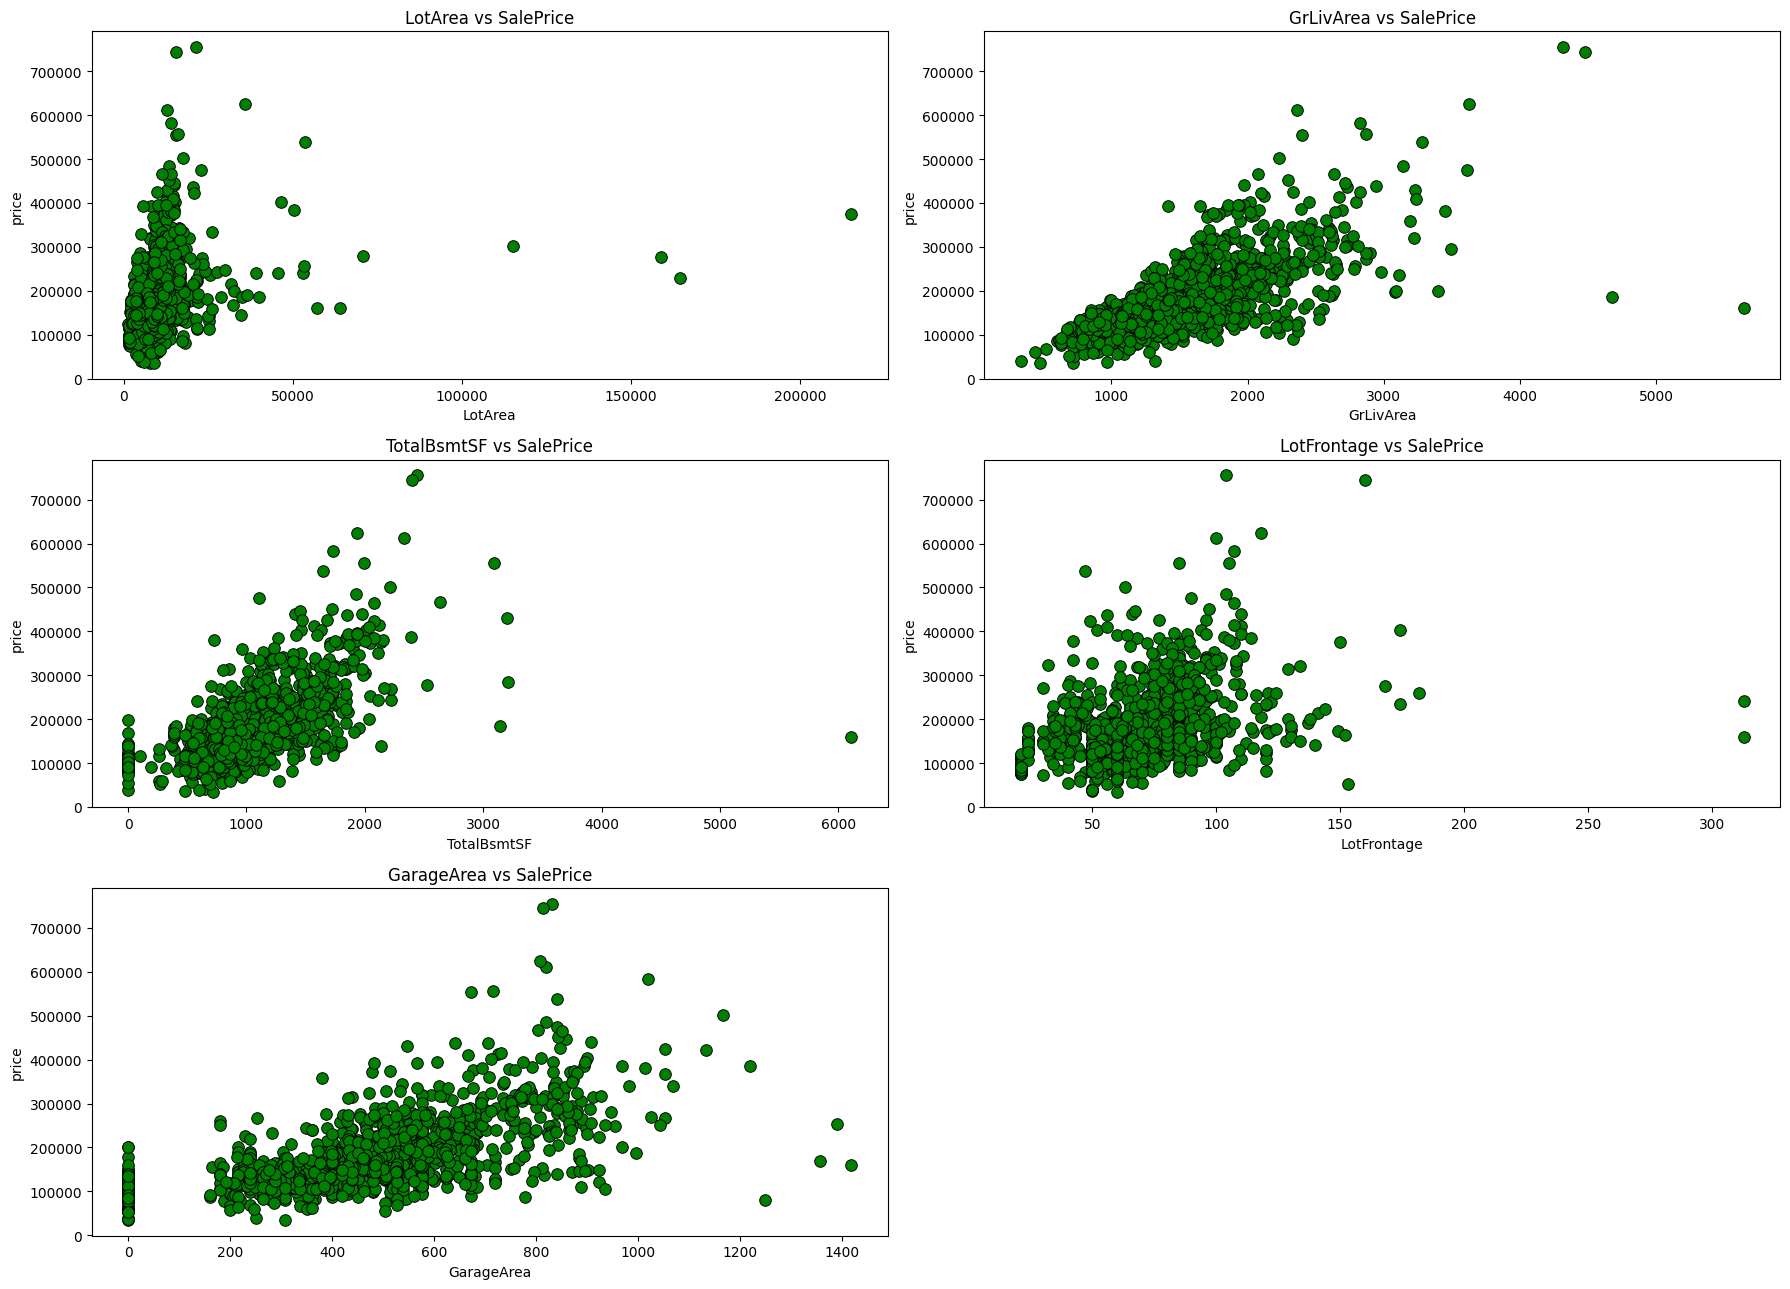

In [28]:
# by above and our experience: we will focus on--> LotArea, GrLivArea, TotalBsmtSF, LotFrontage, GarageArea
# （lower and upper != 0 and related to area）
cols_to_check = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea']
plt.figure(figsize = (18,13))
for i, col in enumerate(cols_to_check, start = 1):
    plt.subplot(3,2,i)
    sns.scatterplot(x = x[col], y = y, alpha = 1, s = 70, color = 'green', edgecolor = 'k')
    plt.title(f'{col} vs SalePrice')
    plt.xlabel(col)
    plt.ylabel('price')  

plt.tight_layout()
plt.show()


In [29]:
# Handle Outliers (Hard Threshold)
outliers_dictionary = {
    'LotArea': 100000,
     'GrLivArea': 4000, 
     'TotalBsmtSF': 4000, 
     'LotFrontage': 200, 
     'GarageArea': 1400
}
for col, threshold in outliers_dictionary.items():
    drop_indexes = x[x[col] > threshold].index
    x = x.drop(index = drop_indexes)
    y = y.drop(index = drop_indexes)



(x['LotArea'] > 100000).sum()

np.int64(0)

# Ordinal_mapping

In [30]:
ordinal_map={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
bsmtFinType_map={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
bsmtExpo_map={'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0}

ord_cols=['ExterQual','ExterCond','BsmtQual','BsmtCond',
         'HeatingQC','KitchenQual','GarageQual','GarageCond']

fin_cols=['BsmtFinType1','BsmtFinType2']
expo_cols = ['BsmtExposure']

def apply_ordinal(train_df, test_df, cols, mapping, fill=0, dtype='int16'):
    for col in cols:
        if col in train_df.columns:
            train_df[col] = train_df[col].map(mapping).fillna(fill).astype(dtype)
        if col in test_df.columns:
            test_df[col] = test_df[col].map(mapping).fillna(fill).astype(dtype)

apply_ordinal(x, test_df_copy, ord_cols, ordinal_map)
apply_ordinal(x, test_df_copy, fin_cols, bsmtFinType_map)
apply_ordinal(x, test_df_copy, expo_cols, bsmtExpo_map)

In [31]:
test_df_copy['BsmtExposure']
# check

Id
1461    1
1462    1
1463    1
1464    1
1465    1
       ..
2915    1
2916    1
2917    1
2918    3
2919    3
Name: BsmtExposure, Length: 1459, dtype: int16

# Splitting & Columnstransformer

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import numpy as np

x_train, x_valid, y_train, y_valid = train_test_split(x,y, test_size = 0.2, random_state = 35)

num_transformer = SimpleImputer(strategy = 'mean')

cat_transformer = Pipeline(steps = [('cat_null', SimpleImputer(strategy = 'most_frequent')),
                                    ('cat_OHE', OneHotEncoder(handle_unknown = 'ignore'))])

num, cat = split_num_cat(x_train)

cols_transformer = ColumnTransformer(transformers = [('num_transformer', num_transformer, num),
                                                     ('cat_transformer', cat_transformer, cat)])

# Find our model parameters

In [33]:
import optuna as opt
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
cv5 = KFold(n_splits = 5, shuffle= True, random_state= 35)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 1200, 3600),
        "learning_rate": trial.suggest_float("learning_rate", 0.008, 0.04),  # 降低学习率，提升上限
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.6, 1.0),
  
         "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),
  
        "max_bin": trial.suggest_int("max_bin", 180, 256)
    }

    xgb_model = XGBRegressor(
        **params,
       device = 'cpu',
       tree_method =  'hist',
       grow_policy='lossguide',
       n_jobs = 2,
       random_state = 35
    )
   
    xgb_pipe = Pipeline(steps = [('cols_transformer', cols_transformer),('xgb_model', xgb_model)])

    score = -cross_val_score(xgb_pipe, x, y, cv =cv5, scoring = 'neg_root_mean_squared_error').mean()
    return score

study = opt.create_study(study_name = 'study', direction = 'minimize', sampler = TPESampler(seed = 35), pruner= MedianPruner(n_warmup_steps= 10))
study.optimize(objective, show_progress_bar = True, n_jobs = -1, n_trials = 50)

goat_param = study.best_params

goat_score = study.best_value

print(f'our best param is {goat_param}')
print(f'our best model score is {goat_score}')

[I 2025-10-22 01:02:57,880] A new study created in memory with name: study
Best trial: 5. Best value: 22011.6:   2%|▏         | 1/50 [00:16<13:51, 16.98s/it]

[I 2025-10-22 01:03:14,854] Trial 5 finished with value: 22011.59296875 and parameters: {'n_estimators': 1958, 'learning_rate': 0.037556798186515965, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7582697327255078, 'colsample_bytree': 0.7001415755303735, 'gamma': 4.716656113794364, 'colsample_bynode': 0.9178216502445935, 'reg_alpha': 0.753264799549906, 'reg_lambda': 2.3618413598582526, 'max_bin': 191}. Best is trial 5 with value: 22011.59296875.


Best trial: 5. Best value: 22011.6:   4%|▍         | 2/50 [00:38<15:37, 19.53s/it]

[I 2025-10-22 01:03:36,168] Trial 2 finished with value: 22564.2234375 and parameters: {'n_estimators': 1471, 'learning_rate': 0.03826653387649657, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7644220211888593, 'colsample_bytree': 0.8359664558348665, 'gamma': 3.7371548202504408, 'colsample_bynode': 0.636321498946611, 'reg_alpha': 0.9235877903821248, 'reg_lambda': 2.3532037963684242, 'max_bin': 218}. Best is trial 5 with value: 22011.59296875.


Best trial: 0. Best value: 21946.1:   6%|▌         | 3/50 [00:39<08:51, 11.31s/it]

[I 2025-10-22 01:03:37,710] Trial 0 finished with value: 21946.1 and parameters: {'n_estimators': 3065, 'learning_rate': 0.034526602023284926, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8277715680882315, 'colsample_bytree': 0.6647685387172865, 'gamma': 1.5138783970307523, 'colsample_bynode': 0.6685331822871174, 'reg_alpha': 0.8609940313505461, 'reg_lambda': 1.5447005612435858, 'max_bin': 240}. Best is trial 0 with value: 21946.1.


Best trial: 0. Best value: 21946.1:  10%|█         | 5/50 [00:56<06:32,  8.73s/it]

[I 2025-10-22 01:03:54,714] Trial 4 finished with value: 22428.65859375 and parameters: {'n_estimators': 1595, 'learning_rate': 0.021611266574373587, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.6404455039031703, 'colsample_bytree': 0.6533382170663188, 'gamma': 0.9471863333818792, 'colsample_bynode': 0.7085577639798943, 'reg_alpha': 0.4824978212346105, 'reg_lambda': 2.3991950971959657, 'max_bin': 188}. Best is trial 0 with value: 21946.1.
[I 2025-10-22 01:03:54,868] Trial 3 finished with value: 23415.9828125 and parameters: {'n_estimators': 1460, 'learning_rate': 0.009384961153962671, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8237940634756875, 'colsample_bytree': 0.9553026250002044, 'gamma': 0.4024535398927559, 'colsample_bynode': 0.6167681947900071, 'reg_alpha': 0.29933818381569, 'reg_lambda': 1.816929073377437, 'max_bin': 213}. Best is trial 0 with value: 21946.1.


Best trial: 0. Best value: 21946.1:  12%|█▏        | 6/50 [00:59<04:49,  6.58s/it]

[I 2025-10-22 01:03:57,296] Trial 8 finished with value: 22268.6796875 and parameters: {'n_estimators': 2259, 'learning_rate': 0.03050726251686876, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8702156384505472, 'colsample_bytree': 0.7337896734072659, 'gamma': 2.1518781833527374, 'colsample_bynode': 0.800377269881756, 'reg_alpha': 0.9233038675659847, 'reg_lambda': 1.0509167344156685, 'max_bin': 237}. Best is trial 0 with value: 21946.1.


Best trial: 0. Best value: 21946.1:  14%|█▍        | 7/50 [01:09<05:30,  7.70s/it]

[I 2025-10-22 01:04:07,276] Trial 1 finished with value: 22100.88671875 and parameters: {'n_estimators': 3181, 'learning_rate': 0.008061055310146177, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.678093534862274, 'colsample_bytree': 0.7336619593681991, 'gamma': 2.7647373723342343, 'colsample_bynode': 0.8763295758300198, 'reg_alpha': 0.9386480137529173, 'reg_lambda': 0.6466925951383127, 'max_bin': 204}. Best is trial 0 with value: 21946.1.


Best trial: 0. Best value: 21946.1:  16%|█▌        | 8/50 [01:14<04:46,  6.82s/it]

[I 2025-10-22 01:04:12,225] Trial 9 finished with value: 22574.4921875 and parameters: {'n_estimators': 2690, 'learning_rate': 0.02921092858846995, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.937309660637797, 'colsample_bytree': 0.7677709520469272, 'gamma': 0.0027613212528615483, 'colsample_bynode': 0.9794691031132949, 'reg_alpha': 0.9659405316984371, 'reg_lambda': 0.9995861886159764, 'max_bin': 247}. Best is trial 0 with value: 21946.1.


Best trial: 0. Best value: 21946.1:  18%|█▊        | 9/50 [01:21<04:46,  6.99s/it]

[I 2025-10-22 01:04:19,588] Trial 6 finished with value: 23442.662890625 and parameters: {'n_estimators': 1233, 'learning_rate': 0.015184354764832321, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.7421547731407221, 'colsample_bytree': 0.6598613706961803, 'gamma': 1.147337997149468, 'colsample_bynode': 0.8922444452782948, 'reg_alpha': 0.27307178545125577, 'reg_lambda': 2.643879513631823, 'max_bin': 226}. Best is trial 0 with value: 21946.1.


Best trial: 14. Best value: 21762.4:  20%|██        | 10/50 [01:35<05:58,  8.96s/it]

[I 2025-10-22 01:04:32,958] Trial 14 finished with value: 21762.434765625 and parameters: {'n_estimators': 3119, 'learning_rate': 0.01655395197770873, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8579025737488112, 'colsample_bytree': 0.676282893333266, 'gamma': 4.167709577268975, 'colsample_bynode': 0.841131523418329, 'reg_alpha': 0.43402172610956047, 'reg_lambda': 2.053723476989621, 'max_bin': 223}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  22%|██▏       | 11/50 [01:44<05:58,  9.20s/it]

[I 2025-10-22 01:04:42,704] Trial 13 finished with value: 22292.6421875 and parameters: {'n_estimators': 1986, 'learning_rate': 0.02206699230227932, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6559637775510717, 'colsample_bytree': 0.6025034310430012, 'gamma': 3.709021715053247, 'colsample_bynode': 0.9587171805709955, 'reg_alpha': 0.44096663858177076, 'reg_lambda': 1.1893052583816273, 'max_bin': 222}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  24%|██▍       | 12/50 [01:56<06:22, 10.06s/it]

[I 2025-10-22 01:04:54,723] Trial 10 finished with value: 23506.101953125 and parameters: {'n_estimators': 1650, 'learning_rate': 0.018413197675701865, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8974199864508777, 'colsample_bytree': 0.6568441319767517, 'gamma': 0.055771659491500314, 'colsample_bynode': 0.8946541787845991, 'reg_alpha': 0.7159375140438369, 'reg_lambda': 1.276500992945954, 'max_bin': 209}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  28%|██▊       | 14/50 [02:10<04:43,  7.87s/it]

[I 2025-10-22 01:05:08,632] Trial 7 finished with value: 22400.039453125 and parameters: {'n_estimators': 3068, 'learning_rate': 0.0196838687280344, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.6493714185653984, 'colsample_bytree': 0.6120959371400042, 'gamma': 0.7785610729301301, 'colsample_bynode': 0.7320515413648636, 'reg_alpha': 0.7647991198421373, 'reg_lambda': 2.768189491861021, 'max_bin': 215}. Best is trial 14 with value: 21762.434765625.
[I 2025-10-22 01:05:08,752] Trial 12 finished with value: 22537.512890625 and parameters: {'n_estimators': 2657, 'learning_rate': 0.009634068590081405, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8422014551751162, 'colsample_bytree': 0.8689333687562779, 'gamma': 2.612093646989759, 'colsample_bynode': 0.8449671891400309, 'reg_alpha': 0.063370600282739, 'reg_lambda': 2.808245881314028, 'max_bin': 212}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  30%|███       | 15/50 [02:12<03:29,  5.99s/it]

[I 2025-10-22 01:05:10,391] Trial 11 finished with value: 22471.18046875 and parameters: {'n_estimators': 1994, 'learning_rate': 0.02142255741544401, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.679687621443147, 'colsample_bytree': 0.6452000133988881, 'gamma': 2.56886389883416, 'colsample_bynode': 0.7399162764688312, 'reg_alpha': 0.342548995101685, 'reg_lambda': 0.567866202720376, 'max_bin': 204}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  32%|███▏      | 16/50 [02:14<02:43,  4.80s/it]

[I 2025-10-22 01:05:12,424] Trial 18 finished with value: 21949.75 and parameters: {'n_estimators': 3541, 'learning_rate': 0.015638057513956038, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8640960938917556, 'colsample_bytree': 0.8347602352352675, 'gamma': 2.2075953265455377, 'colsample_bynode': 0.7551901192812581, 'reg_alpha': 0.018664869032949782, 'reg_lambda': 1.786528817028783, 'max_bin': 255}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  34%|███▍      | 17/50 [02:21<02:59,  5.44s/it]

[I 2025-10-22 01:05:19,356] Trial 15 finished with value: 22350.705859375 and parameters: {'n_estimators': 3592, 'learning_rate': 0.016059398842971983, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8746519330704471, 'colsample_bytree': 0.8978594620444608, 'gamma': 3.1940078288498857, 'colsample_bynode': 0.7714253418605356, 'reg_alpha': 0.6846311832806122, 'reg_lambda': 2.224551099525348, 'max_bin': 246}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  36%|███▌      | 18/50 [02:27<02:57,  5.54s/it]

[I 2025-10-22 01:05:25,127] Trial 16 finished with value: 22713.83203125 and parameters: {'n_estimators': 3169, 'learning_rate': 0.039783990335302506, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8747317241126521, 'colsample_bytree': 0.7053091413706848, 'gamma': 4.090279865017742, 'colsample_bynode': 0.809611814565855, 'reg_alpha': 0.3578983356011852, 'reg_lambda': 1.4959480104482632, 'max_bin': 225}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  38%|███▊      | 19/50 [02:27<02:03,  3.99s/it]

[I 2025-10-22 01:05:25,512] Trial 19 finished with value: 22078.99921875 and parameters: {'n_estimators': 3540, 'learning_rate': 0.028159341038615785, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.823395632267396, 'colsample_bytree': 0.8259198691418903, 'gamma': 2.036611014774507, 'colsample_bynode': 0.7741648930637275, 'reg_alpha': 0.06074570731045098, 'reg_lambda': 1.8384255735975137, 'max_bin': 253}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  40%|████      | 20/50 [02:41<03:26,  6.89s/it]

[I 2025-10-22 01:05:39,160] Trial 21 finished with value: 21949.846484375 and parameters: {'n_estimators': 3568, 'learning_rate': 0.02773936551403212, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8173235804114812, 'colsample_bytree': 0.7970913153869243, 'gamma': 1.7675752883042515, 'colsample_bynode': 0.7312435443187189, 'reg_alpha': 0.6250311561318016, 'reg_lambda': 1.6441171546384563, 'max_bin': 256}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  42%|████▏     | 21/50 [02:42<02:27,  5.10s/it]

[I 2025-10-22 01:05:40,081] Trial 20 finished with value: 22050.220703125 and parameters: {'n_estimators': 3517, 'learning_rate': 0.028246093433210565, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8298448542575675, 'colsample_bytree': 0.8405416261114441, 'gamma': 1.8903776755571882, 'colsample_bynode': 0.7997673179628836, 'reg_alpha': 0.025975634438344608, 'reg_lambda': 1.8078110538165255, 'max_bin': 255}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  44%|████▍     | 22/50 [02:43<01:53,  4.06s/it]

[I 2025-10-22 01:05:41,721] Trial 22 finished with value: 21989.583203125 and parameters: {'n_estimators': 3541, 'learning_rate': 0.027829312435905217, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8007307421100394, 'colsample_bytree': 0.8083040954477168, 'gamma': 1.7342028506368479, 'colsample_bynode': 0.7803281580452277, 'reg_alpha': 0.6354566600731627, 'reg_lambda': 1.7867884531027662, 'max_bin': 255}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  46%|████▌     | 23/50 [02:52<02:25,  5.40s/it]

[I 2025-10-22 01:05:50,251] Trial 23 finished with value: 21843.167578125 and parameters: {'n_estimators': 3162, 'learning_rate': 0.02700088140378219, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8085561123241549, 'colsample_bytree': 0.7104430581451174, 'gamma': 4.948210485313722, 'colsample_bynode': 0.6810840846327388, 'reg_alpha': 0.6038563387676792, 'reg_lambda': 1.5511381738930083, 'max_bin': 234}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  48%|████▊     | 24/50 [02:57<02:18,  5.32s/it]

[I 2025-10-22 01:05:55,377] Trial 24 finished with value: 21840.074609375 and parameters: {'n_estimators': 3059, 'learning_rate': 0.027020940190704404, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8009716055106073, 'colsample_bytree': 0.7114789602042898, 'gamma': 4.746213212416322, 'colsample_bynode': 0.6883158101187269, 'reg_alpha': 0.612104080112851, 'reg_lambda': 1.499754951394937, 'max_bin': 232}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  50%|█████     | 25/50 [03:07<02:47,  6.69s/it]

[I 2025-10-22 01:06:05,266] Trial 26 finished with value: 22137.7140625 and parameters: {'n_estimators': 2836, 'learning_rate': 0.03280849611363952, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.790202789978981, 'colsample_bytree': 0.7787308409558651, 'gamma': 1.5661639288321914, 'colsample_bynode': 0.6677727273491892, 'reg_alpha': 0.623595253135509, 'reg_lambda': 2.0538990020711725, 'max_bin': 233}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  52%|█████▏    | 26/50 [03:07<01:54,  4.76s/it]

[I 2025-10-22 01:06:05,536] Trial 25 finished with value: 22543.4734375 and parameters: {'n_estimators': 2848, 'learning_rate': 0.026862381870847125, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8129410496952464, 'colsample_bytree': 0.7808419978507121, 'gamma': 1.443699673265712, 'colsample_bynode': 0.6617274358554955, 'reg_alpha': 0.6012343843715489, 'reg_lambda': 1.9869553102126594, 'max_bin': 233}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  54%|█████▍    | 27/50 [03:15<02:13,  5.82s/it]

[I 2025-10-22 01:06:13,829] Trial 27 finished with value: 22302.120703125 and parameters: {'n_estimators': 2824, 'learning_rate': 0.03276341203890096, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9191294068224429, 'colsample_bytree': 0.6996406268639666, 'gamma': 1.5687940962791513, 'colsample_bynode': 0.6994250636249338, 'reg_alpha': 0.6056505135456969, 'reg_lambda': 2.045462039185249, 'max_bin': 234}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  56%|█████▌    | 28/50 [03:21<02:04,  5.67s/it]

[I 2025-10-22 01:06:19,161] Trial 28 finished with value: 22147.49140625 and parameters: {'n_estimators': 2977, 'learning_rate': 0.013285560104037872, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9349851769638045, 'colsample_bytree': 0.9331222154260124, 'gamma': 1.3919549533792244, 'colsample_bynode': 0.6507735997418621, 'reg_alpha': 0.19055458130466016, 'reg_lambda': 2.0275796355426685, 'max_bin': 238}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  58%|█████▊    | 29/50 [03:22<01:32,  4.42s/it]

[I 2025-10-22 01:06:20,651] Trial 29 finished with value: 22131.389453125 and parameters: {'n_estimators': 3011, 'learning_rate': 0.012855157376106645, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9294319738034582, 'colsample_bytree': 0.9109144410334796, 'gamma': 1.4014233174343202, 'colsample_bynode': 0.6577500484147801, 'reg_alpha': 0.1743530365260309, 'reg_lambda': 2.064805346752684, 'max_bin': 233}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  60%|██████    | 30/50 [03:24<01:11,  3.57s/it]

[I 2025-10-22 01:06:22,253] Trial 17 finished with value: 22790.7328125 and parameters: {'n_estimators': 3583, 'learning_rate': 0.02170019333435328, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9491331533724223, 'colsample_bytree': 0.827968081101818, 'gamma': 4.964662619097123, 'colsample_bynode': 0.7615885223303109, 'reg_alpha': 0.0032376359328896154, 'reg_lambda': 2.9888446743725927, 'max_bin': 256}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  62%|██████▏   | 31/50 [03:29<01:15,  3.99s/it]

[I 2025-10-22 01:06:27,201] Trial 30 finished with value: 22058.797265625 and parameters: {'n_estimators': 2901, 'learning_rate': 0.03418005675544593, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7267929617663756, 'colsample_bytree': 0.6924317199893315, 'gamma': 4.856526361642252, 'colsample_bynode': 0.672005268165357, 'reg_alpha': 0.8295409002456331, 'reg_lambda': 2.0488618490743735, 'max_bin': 234}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  64%|██████▍   | 32/50 [03:33<01:11,  3.96s/it]

[I 2025-10-22 01:06:31,089] Trial 31 finished with value: 21783.184765625 and parameters: {'n_estimators': 2834, 'learning_rate': 0.02479103391762908, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7243130291458646, 'colsample_bytree': 0.7019688993568576, 'gamma': 4.817426523093275, 'colsample_bynode': 0.6738321706764475, 'reg_alpha': 0.5820176521190433, 'reg_lambda': 2.0525996400360103, 'max_bin': 234}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  66%|██████▌   | 33/50 [03:49<02:09,  7.64s/it]

[I 2025-10-22 01:06:47,320] Trial 33 finished with value: 21977.68515625 and parameters: {'n_estimators': 3323, 'learning_rate': 0.02408766126963819, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7255216135682042, 'colsample_bytree': 0.6996369736280936, 'gamma': 4.79011836580203, 'colsample_bynode': 0.6949955912411091, 'reg_alpha': 0.5265623854157917, 'reg_lambda': 1.391044663259078, 'max_bin': 229}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  68%|██████▊   | 34/50 [03:51<01:33,  5.87s/it]

[I 2025-10-22 01:06:49,056] Trial 32 finished with value: 21782.0296875 and parameters: {'n_estimators': 3306, 'learning_rate': 0.02529748405006716, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7241814819895784, 'colsample_bytree': 0.7008936182513239, 'gamma': 4.834635375510128, 'colsample_bynode': 0.8337873368471093, 'reg_alpha': 0.5336884128269652, 'reg_lambda': 2.0362670936998404, 'max_bin': 231}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  70%|███████   | 35/50 [03:56<01:27,  5.81s/it]

[I 2025-10-22 01:06:54,740] Trial 34 finished with value: 21880.708984375 and parameters: {'n_estimators': 3283, 'learning_rate': 0.024907385487206765, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7375524382488077, 'colsample_bytree': 0.7407832571259662, 'gamma': 4.847569571209464, 'colsample_bynode': 0.6110798128198105, 'reg_alpha': 0.5316200663502779, 'reg_lambda': 1.3574259652040455, 'max_bin': 229}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  72%|███████▏  | 36/50 [04:06<01:36,  6.89s/it]

[I 2025-10-22 01:07:04,135] Trial 35 finished with value: 22126.648046875 and parameters: {'n_estimators': 2431, 'learning_rate': 0.025505960377067514, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7256632995534975, 'colsample_bytree': 0.7419161619237755, 'gamma': 4.974432151806625, 'colsample_bynode': 0.8314244140104746, 'reg_alpha': 0.5392137688946969, 'reg_lambda': 1.276955320582737, 'max_bin': 228}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  74%|███████▍  | 37/50 [04:22<02:06,  9.75s/it]

[I 2025-10-22 01:07:20,577] Trial 36 finished with value: 22033.31015625 and parameters: {'n_estimators': 3236, 'learning_rate': 0.02453208629481262, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7318159898542282, 'colsample_bytree': 0.7438734906847253, 'gamma': 4.74418496412406, 'colsample_bynode': 0.7021781766417954, 'reg_alpha': 0.8252534706649405, 'reg_lambda': 1.4819272493216955, 'max_bin': 242}. Best is trial 14 with value: 21762.434765625.


Best trial: 14. Best value: 21762.4:  76%|███████▌  | 38/50 [04:24<01:27,  7.33s/it]

[I 2025-10-22 01:07:22,238] Trial 37 finished with value: 22232.846875 and parameters: {'n_estimators': 3303, 'learning_rate': 0.025164254051385625, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7294088152533458, 'colsample_bytree': 0.7474160420015905, 'gamma': 4.47569930476057, 'colsample_bynode': 0.6023510713966147, 'reg_alpha': 0.5252322190991497, 'reg_lambda': 1.4551439673095965, 'max_bin': 245}. Best is trial 14 with value: 21762.434765625.


Best trial: 39. Best value: 21698.3:  78%|███████▊  | 39/50 [04:30<01:17,  7.02s/it]

[I 2025-10-22 01:07:28,531] Trial 39 finished with value: 21698.303125 and parameters: {'n_estimators': 3268, 'learning_rate': 0.024756623522674447, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6009269488119007, 'colsample_bytree': 0.7366398945121047, 'gamma': 4.401043590964452, 'colsample_bynode': 0.6104594323124956, 'reg_alpha': 0.5398642313486648, 'reg_lambda': 1.5093345011146775, 'max_bin': 244}. Best is trial 39 with value: 21698.303125.


Best trial: 39. Best value: 21698.3:  80%|████████  | 40/50 [04:35<01:03,  6.37s/it]

[I 2025-10-22 01:07:33,406] Trial 38 finished with value: 22335.154296875 and parameters: {'n_estimators': 3334, 'learning_rate': 0.02497517178609381, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8484151008469574, 'colsample_bytree': 0.7368822615840688, 'gamma': 4.3291127999560475, 'colsample_bynode': 0.6096815709819543, 'reg_alpha': 0.5260275939770241, 'reg_lambda': 1.4822001012888149, 'max_bin': 243}. Best is trial 39 with value: 21698.303125.


Best trial: 39. Best value: 21698.3:  82%|████████▏ | 41/50 [04:45<01:07,  7.53s/it]

[I 2025-10-22 01:07:43,637] Trial 42 finished with value: 22043.131640625 and parameters: {'n_estimators': 2529, 'learning_rate': 0.02456118609783564, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6933643166383803, 'colsample_bytree': 0.6259704484187867, 'gamma': 4.448181807150779, 'colsample_bynode': 0.8371422679663015, 'reg_alpha': 0.41517565936848627, 'reg_lambda': 2.197815748928687, 'max_bin': 243}. Best is trial 39 with value: 21698.303125.


Best trial: 45. Best value: 21655.2:  84%|████████▍ | 42/50 [04:47<00:45,  5.69s/it]

[I 2025-10-22 01:07:45,050] Trial 45 finished with value: 21655.1625 and parameters: {'n_estimators': 2643, 'learning_rate': 0.030300795602849033, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7062330661866942, 'colsample_bytree': 0.6329441524158413, 'gamma': 4.310358039962864, 'colsample_bynode': 0.8516613830029163, 'reg_alpha': 0.4008871195206719, 'reg_lambda': 2.2288263332112956, 'max_bin': 223}. Best is trial 45 with value: 21655.1625.


Best trial: 45. Best value: 21655.2:  86%|████████▌ | 43/50 [04:50<00:34,  4.96s/it]

[I 2025-10-22 01:07:48,305] Trial 40 finished with value: 22013.236328125 and parameters: {'n_estimators': 3253, 'learning_rate': 0.024417371097379067, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.781104812673512, 'colsample_bytree': 0.7383570859241629, 'gamma': 4.396289302029938, 'colsample_bynode': 0.6121265551778461, 'reg_alpha': 0.5303194911751564, 'reg_lambda': 1.5877761832208128, 'max_bin': 242}. Best is trial 45 with value: 21655.1625.


Best trial: 45. Best value: 21655.2:  88%|████████▊ | 44/50 [04:54<00:28,  4.82s/it]

[I 2025-10-22 01:07:52,808] Trial 44 finished with value: 21730.121875 and parameters: {'n_estimators': 3356, 'learning_rate': 0.018647735344225123, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6818063195107589, 'colsample_bytree': 0.9922521991960993, 'gamma': 4.355762827161078, 'colsample_bynode': 0.8348094965008624, 'reg_alpha': 0.433462360308081, 'reg_lambda': 2.5040331688659125, 'max_bin': 220}. Best is trial 45 with value: 21655.1625.


Best trial: 47. Best value: 21532.1:  90%|█████████ | 45/50 [04:56<00:19,  3.85s/it]

[I 2025-10-22 01:07:54,397] Trial 47 finished with value: 21532.140625 and parameters: {'n_estimators': 2643, 'learning_rate': 0.01855178576491712, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6078105824284268, 'colsample_bytree': 0.6779512767730437, 'gamma': 3.7745364079895927, 'colsample_bynode': 0.6316017502994546, 'reg_alpha': 0.44835301348297496, 'reg_lambda': 2.4960686894609485, 'max_bin': 220}. Best is trial 47 with value: 21532.140625.


Best trial: 47. Best value: 21532.1:  92%|█████████▏| 46/50 [04:58<00:12,  3.15s/it]

[I 2025-10-22 01:07:55,903] Trial 41 finished with value: 21969.233984375 and parameters: {'n_estimators': 3364, 'learning_rate': 0.024463179540451054, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6981093530875757, 'colsample_bytree': 0.7419736739153553, 'gamma': 4.402878322245491, 'colsample_bynode': 0.8397975534885272, 'reg_alpha': 0.5305080507002043, 'reg_lambda': 2.498309259507194, 'max_bin': 243}. Best is trial 47 with value: 21532.140625.


Best trial: 47. Best value: 21532.1:  96%|█████████▌| 48/50 [05:05<00:06,  3.19s/it]

[I 2025-10-22 01:08:03,519] Trial 43 finished with value: 21926.6 and parameters: {'n_estimators': 3378, 'learning_rate': 0.01892365828410551, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.7794831161472217, 'colsample_bytree': 0.6310843919409667, 'gamma': 4.340402192353668, 'colsample_bynode': 0.8391377605088686, 'reg_alpha': 0.42840024004028027, 'reg_lambda': 2.2311069357633615, 'max_bin': 242}. Best is trial 47 with value: 21532.140625.
[I 2025-10-22 01:08:03,666] Trial 49 finished with value: 21872.575 and parameters: {'n_estimators': 2718, 'learning_rate': 0.03048448082361935, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6041444445370805, 'colsample_bytree': 0.6760846186061267, 'gamma': 3.8149795873892556, 'colsample_bynode': 0.8556416476172004, 'reg_alpha': 0.4559561474111782, 'reg_lambda': 2.514850321674486, 'max_bin': 220}. Best is trial 47 with value: 21532.140625.


Best trial: 47. Best value: 21532.1:  98%|█████████▊| 49/50 [05:05<00:02,  2.28s/it]

[I 2025-10-22 01:08:03,816] Trial 48 finished with value: 21611.627734375 and parameters: {'n_estimators': 3074, 'learning_rate': 0.03010032431548821, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6232992757119038, 'colsample_bytree': 0.6729160704635864, 'gamma': 3.8381634535344316, 'colsample_bynode': 0.628827922779769, 'reg_alpha': 0.4380772715294334, 'reg_lambda': 2.5147940487189873, 'max_bin': 180}. Best is trial 47 with value: 21532.140625.


Best trial: 47. Best value: 21532.1: 100%|██████████| 50/50 [05:08<00:00,  6.16s/it]

[I 2025-10-22 01:08:06,030] Trial 46 finished with value: 21998.291015625 and parameters: {'n_estimators': 2650, 'learning_rate': 0.03048394842325273, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.6020742344961265, 'colsample_bytree': 0.6752828260441287, 'gamma': 4.3908932692230405, 'colsample_bynode': 0.8370713794091341, 'reg_alpha': 0.4361049703742288, 'reg_lambda': 2.2083244453349264, 'max_bin': 220}. Best is trial 47 with value: 21532.140625.
our best param is {'n_estimators': 2643, 'learning_rate': 0.01855178576491712, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6078105824284268, 'colsample_bytree': 0.6779512767730437, 'gamma': 3.7745364079895927, 'colsample_bynode': 0.6316017502994546, 'reg_alpha': 0.44835301348297496, 'reg_lambda': 2.4960686894609485, 'max_bin': 220}
our best model score is 21532.140625


# Deliver our prediction!

In [34]:
final_xgb_model = XGBRegressor(
        **goat_param,
        device = 'cpu',
        tree_method =  'hist',
        grow_policy='lossguide',
        n_jobs = 2,
        random_state = 35
)
final_xgb_pipe = Pipeline(steps = [('cols_transformer', cols_transformer),('final_xgb_model', final_xgb_model)])

final_xgb_pipe.fit(x,y)
y_prediction = final_xgb_pipe.predict(test_df_copy)

output = pd.DataFrame({'Id': test_df_copy.index,
                      'SalePrice': y_prediction})
output.to_csv('submission_feature_engineering.csv', index = False)
